In [1]:
using PyPlot
using DataFrames
using CSV
import Statistics

In [2]:
include("./src/loop_function.jl")
include("./src/tmat.jl")
include("./src/tmat_up_to_nlo.jl")
include("./src/par.jl")
include("./src/subtraction_cons.jl")

subtraction_cons_tuple (generic function with 1 method)

In [3]:
import PyCall
iminuit = PyCall.pyimport("iminuit");

In [4]:
par_phy_channel = par_physical_channel()
# par_phy_channel[:decons] = 106.0

Dict{Symbol, Any} with 4 entries:
  :threshold  => [1431.95, 1328.94, 1327.62, 1437.22, 1337.02, 1250.66]
  :mch        => [(493.68, 938.272), (139.57, 1189.37), (134.977, 1192.64), (49…
  :meson_mass => (139.57, 134.977, 139.57, 497.65, 493.68)
  :decons     => 100.69

In [5]:
b = (-0.664609603537589, 0.062434962905761365, -0.35384103271852047)
d = (-0.46011427499158786, 0.05501054906425522, -0.06775661407295062, -0.5884345325719142);

In [6]:
D = lec_bi(par_phy_channel, b)
L = lec_di(d);

In [7]:
w = range(1320., 1550., 250)
vnlo11 = [real(vnlo_swave(ww, par_phy_channel, D, L, n=6)[1, 1] ) for ww in w]
vnlo14 = [real(vnlo_swave(ww, par_phy_channel, D, L, n=6)[1, 4] ) for ww in w]

vlo11 = [real(WT(ww, par_phy_channel, lecs_cij(), n=6)[1, 1]) for ww in w]
vlo14 = [real(WT(ww, par_phy_channel, lecs_cij(), n=6)[1, 4]) for ww in w];

In [8]:
D, F = 0.8, 0.46;

In [9]:
function VC(w, par, (mi, Mi), (mj, Mj), Mk)
    s = w*w
    f = par[:decons]
    Ni = norm_factor(w, (mi, Mi) )
    Nj = norm_factor(w, (mj, Mj) )
    Ei = baryon_energy(w, (mi, Mi) )
    Ej = baryon_energy(w, (mj, Mj) )
    qi = qcm(w, mi, Mi)
    qj = qcm(w, mj, Mj)
    v = Ni * Nj * (w + Mk - (Mi + Mk) * (mj + Mk) / (2e0(Mi + Ei)*(Ej + Mj)) * (w - Mk + Mi + Mj) +
    (Mi + Mk)*(Mj + Mk)/(4e0qi*qj) * (w + Mk - Mi - Mj - (s + Mk^2 - mi^2 -mj^2 -2e0Ei*Ej) / (2e0 *(Mi + Ei) * (Mj + Ej)) * (w - Mk + Mi + Mj) ) *
    log((s + Mk^2 - mi^2 -mj^2 -2e0Ei*Ej - 2e0*qi*qj) / (s + Mk^2 - mi^2 - mj^2 -2e0Ei*Ej + 2e0qi*qj) )
    )
    return v
end

function VC11(w, par, (mi, Mi), Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ = sqrt(3.)*(D - F)
    return CΛ^2 * VC(w, par, (mi, Mi), (mi, Mi), Mk1) + CΣ^2 * VC(w, par, (mi, Mi), (mi, Mi), Mk2)
end

function VC14(w, par, (mi, Mi), (mj, Mj), Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ1 = sqrt(3.) * (D - F)
    CΣ2 = -sqrt(3.) * (D - F)
    return CΛ^2 * VC(w, par, (mi, Mi), (mi, Mj), Mk1) + CΣ1 * CΣ2 * VC(w, par, (mi, Mi), (mi, Mj), Mk2)
end

VC14 (generic function with 1 method)

In [10]:
function VD(w, par, (mi, Mi), (mj, Mj), Mk)
    s = w*w
    f = par[:decons]
    Ni = norm_factor(w, (mi, Mi) )
    Nj = norm_factor(w, (mj, Mj) )
    return -1. / (12e0f^2) * Ni * Nj * (w - Mi)*(w-Mk)*(w-Mj) / (s - Mk^2)
end

function VD11(w, par, (mi, Mi), Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ = sqrt(3.)*(D - F)
    return CΛ^2 * VD(w, par, (mi, Mi), (mi, Mi), Mk1) + CΣ^2 * VD(w, par, (mi, Mi), (mi, Mi), Mk2)
end
function VD14(w, par, (mi, Mi), (mj, Mj), Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ1 = sqrt(3.) * (D - F)
    CΣ2 = -sqrt(3.) * (D - F)
    return CΛ^2 * VD(w, par, (mi, Mi), (mi, Mj), Mk1) + CΣ1 * CΣ2 * VD(w, par, (mi, Mi), (mi, Mj), Mk2)
end


mkm = 493.68
mkbar0 = 497.65
mp = 938.272
mn = 939.565
mLam = 1115.68
mSig0 = 1192.64;

In [11]:
vd11 = [real(VD11(ww, par_phy_channel, (mkm, mp), mLam, mSig0)) for ww in w]
vd14 = [real(VD14(ww, par_phy_channel, (mkm, mp), (mkbar0, mn), mLam, mSig0)) for ww in w];

vc11 = [real(VC11(ww, par_phy_channel, (mkm, mp), mLam, mSig0)) for ww in w]
vc14 = [real(VC14(ww, par_phy_channel, (mkm, mp), (mkbar0, mn), mLam, mSig0)) for ww in w];

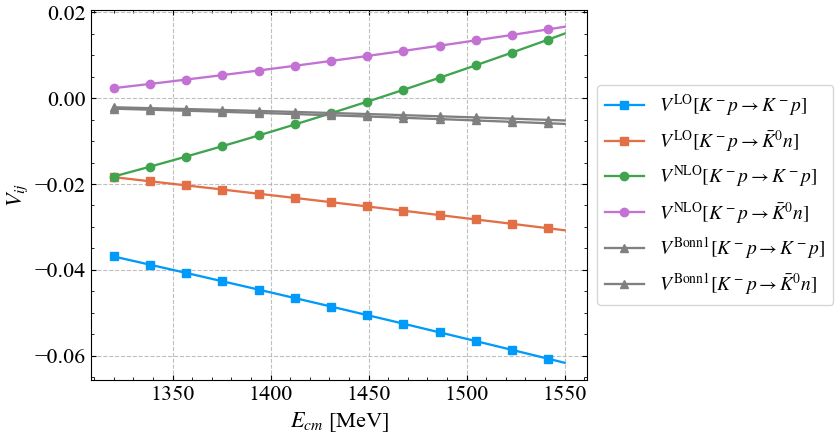

In [14]:

fig, ax = PyPlot.subplots()

ax.plot(w, (vlo11), marker="s", markevery = 20, label=L"V^{\mathrm{LO}}[K^- p \to K^- p]")
ax.plot(w, (vlo14), marker="s", markevery = 20, label=L"V^{\mathrm{LO}}[K^- p \to \bar{K}^0 n]")

ax.plot(w, vnlo11, marker="o", markevery = 20, label=L"V^{\mathrm{NLO}}[K^- p \to K^- p]")
ax.plot(w, vnlo14, marker="o", markevery = 20, label=L"V^{\mathrm{NLO}}[K^- p \to \bar{K}^0 n]")



ax.plot(w, vd11, marker="^", markevery = 20, label=L"V^\mathrm{Bonn1}[K^- p \to K^- p]", c=:gray)
ax.plot(w, vd14, marker="^", markevery = 20, label=L"V^\mathrm{Bonn1}[K^- p \to \bar{K}^0 n]", c=:gray)


# ax.plot(w, vc11, label=L"V^\mathrm{C}[K^- p \to K^- p]")
# ax.plot(w, vc14, label=L"V^\mathrm{C}[K^- p \to \bar{K}^0 n]")

ax.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel=L"$E_{cm}$ [MeV]", ylabel=L"V_{ij}")
ax.grid()
fig.savefig("./figure/potential_conr.png")
fig